In [16]:
import seaborn as sns
import pandas as pd 
import datetime as datetime
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import numpy as np
# Read data from file 'filename.csv' |
# (in the same directory that your python process is based)
# Control delimiters, rows, column names with read_csv (see later)
pd.options.display.float_format = '{:,.2f}'.format
data = pd.read_csv("/home/anconam/projects/Shapley_Pruning/experiments/results/log.csv") 
data['timestamp'].apply(lambda row: str(row))


data.head()

,timestamp,epoch,train_acc,test_acc,train_loss,test_loss,n_params,n_params_full,activations,train_time,prune_time,experiment
0,20200117T221049,1,0.84,0.88,0.46,0.34,16849994,16849994,4096-64-32,34.95,28.45,fmnist__sv-abs-smallest_gap:1.0_steps:10_start...
1,20200117T221049,2,0.89,0.90,0.31,0.31,10748129,16849994,2611-64-32,30.24,5.02,fmnist__sv-abs-smallest_gap:1.0_steps:10_start...
2,20200117T221049,3,0.90,0.90,0.29,0.27,7232834,16849994,2611-43-32,26.39,4.60,fmnist__sv-abs-smallest_gap:1.0_steps:10_start...
3,20200117T221049,4,0.90,0.91,0.26,0.25,7232004,16849994,2611-43-30,25.20,14.70,fmnist__sv-abs-smallest_gap:1.0_steps:10_start...
4,20200117T221049,5,0.91,0.91,0.24,0.24,4854104,16849994,1751-43-30,23.46,2.04,fmnist__sv-abs-smallest_gap:1.0_steps:10_start...


### FMNIST CNN 1.8M parameters

In [17]:
dataset = "fmnist"

plot_df = data[data["experiment"].str.startswith(dataset)]
# plot_df = plot_df[plot_df["timestamp"] >"20200116T18"]

# plot_df = plot_df[plot_df["timestamp"] > "20200117T09"]
# plot_df = plot_df[~plot_df["experiment"].str.contains("prunedyn_sv")]
# plot_df = plot_df[~plot_df["experiment"].str.contains("in1ep")]
# plot_df = plot_df[~plot_df["experiment"].str.contains("random")]
# plot_df = plot_df[~plot_df["experiment"].str.contains("30steps")]

# Some processing
plot_df['test_acc'] *= 100
plot_df['train_acc'] *= 100
plot_df["total_time"] = plot_df["train_time"] + plot_df["prune_time"]
plot_df["sparsity"] = plot_df["n_params"] / plot_df["n_params_full"] * 100
plot_df["test_acc_gap"] = (plot_df["test_acc"] - plot_df["test_acc"].max())


In [18]:
# Rank pruning methods by Test Accuracy at the epoch of Minimum Test Loss
# df_join = plot_df[plot_df["sparsity"] < 100]
# df_join = df_join[df_join["epoch"] > 25]

df_join = plot_df.join(plot_df.groupby(["timestamp"])["test_loss"].min(), on="timestamp", rsuffix="_min")
df_join = df_join[df_join["test_loss"] == df_join["test_loss_min"]]
std = df_join.groupby(["experiment"]).std().sort_values(by=["test_acc"], ascending=False)
df_join = df_join.groupby(["experiment"]).mean().sort_values(by=["test_acc"], ascending=False)
df_join["test_acc_std"] = std["test_acc"]
df_join.filter(["experiment", "test_acc","test_acc_std", "test_acc_gap", "sparsity", "epoch", "test_loss"])

,test_acc,test_acc_std,test_acc_gap,sparsity,epoch,test_loss
experiment,,,,,,
fmnist__grad-abs-smallest_gap:1.0_steps:10_start:1_int:1_load:last,93.43,0.05,-0.35,96.88,5.00,0.29
fmnist__sv-abs-smallest_gap:1.0_steps:10_start:1_int:1_load:last,93.42,0.08,-0.36,60.45,7.33,0.26
fmnist__count-smallest_gap:1.0_steps:10_start:1_int:1_load:last,93.41,0.21,-0.37,98.74,3.00,0.29
fmnist__random_gap:1.0_steps:10_start:1_int:1,93.09,0.17,-0.69,41.30,17.00,0.21
fmnist__sv-abs-smallest_gap:1.0_steps:10_start:1_int:1,93.02,0.47,-0.76,9.45,20.33,0.20
fmnist__random_s:1.0_steps:0_start:1_int:1,92.98,nan,-0.80,100.00,14.00,0.22
fmnist__grad-abs-smallest_gap:1.0_steps:10_start:1_int:1,92.73,0.23,-1.05,31.90,12.67,0.21
fmnist__count-smallest_gap:1.0_steps:10_start:1_int:1,92.60,0.12,-1.18,72.00,14.00,0.22


In [19]:
# Rank pruning methods by best test accuracy during training and sparsity at that stage
# df_join = plot_df[plot_df["sparsity"] < 100]
# df_join = df_join[df_join["epoch"] > 25]

df_join = plot_df[plot_df["sparsity"] < 101]
df_join = df_join.join(df_join.groupby(["timestamp"])["test_acc"].max(), on="timestamp", rsuffix="_max")
df_join = df_join[df_join["test_acc"] == df_join["test_acc_max"]]
df_join = df_join.groupby(["experiment"]).mean().sort_values(by=["test_acc"], ascending=False)
df_join.filter(["experiment", "test_acc", "test_acc_gap", "sparsity", "epoch", "test_loss"])

,test_acc,test_acc_gap,sparsity,epoch,test_loss
experiment,,,,,
fmnist__sv-abs-smallest_gap:1.0_steps:10_start:1_int:1_load:last,93.69,-0.09,56.65,39.00,0.31
fmnist__count-smallest_gap:1.0_steps:10_start:1_int:1_load:last,93.67,-0.11,95.14,36.33,0.33
fmnist__grad-abs-smallest_gap:1.0_steps:10_start:1_int:1_load:last,93.64,-0.14,92.78,26.20,0.31
fmnist__grad-abs-smallest_gap:1.0_steps:10_start:1_int:1,93.59,-0.19,31.90,43.67,0.26
fmnist__random_s:1.0_steps:0_start:1_int:1,93.53,-0.25,100.00,42.00,0.28
fmnist__sv-abs-smallest_gap:1.0_steps:10_start:1_int:1,93.51,-0.27,9.45,47.33,0.24
fmnist__random_gap:1.0_steps:10_start:1_int:1,93.48,-0.30,41.30,42.67,0.26
fmnist__count-smallest_gap:1.0_steps:10_start:1_int:1,93.39,-0.39,72.00,48.33,0.28


Accuracy
Training time
Sparsity


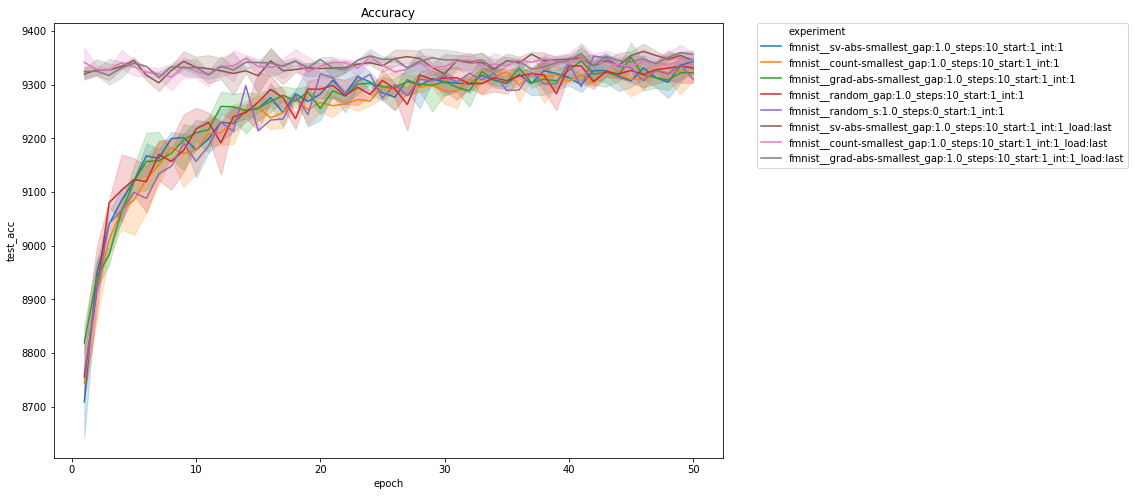

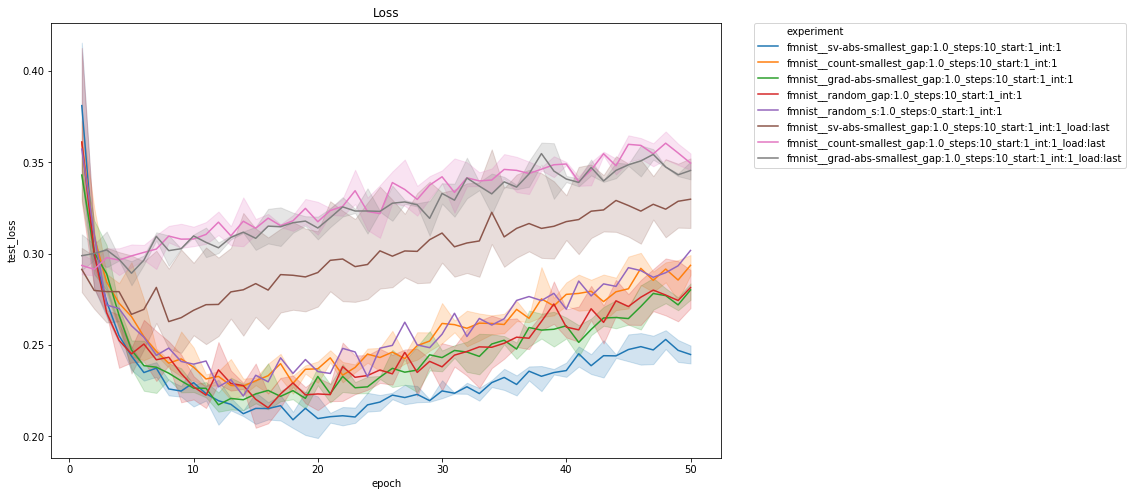

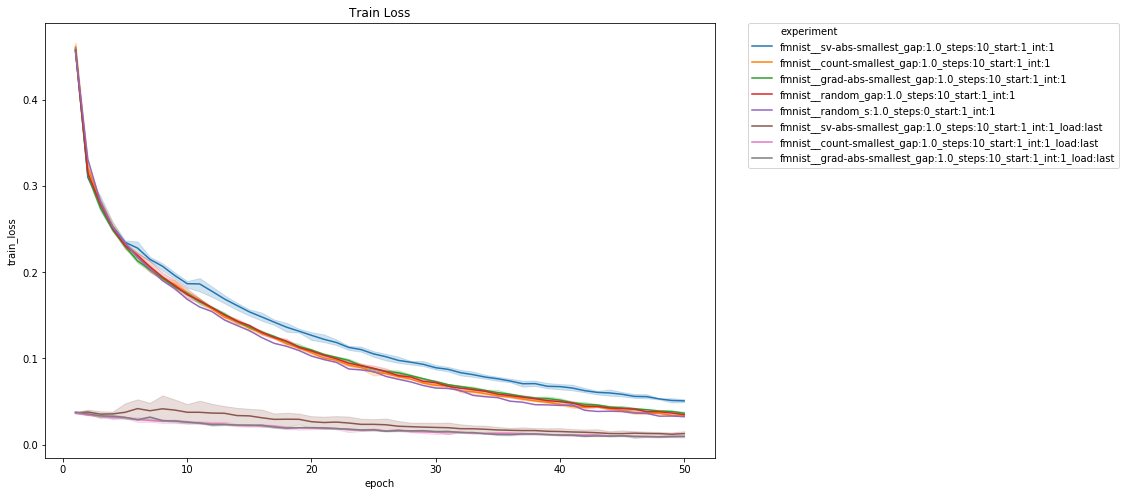

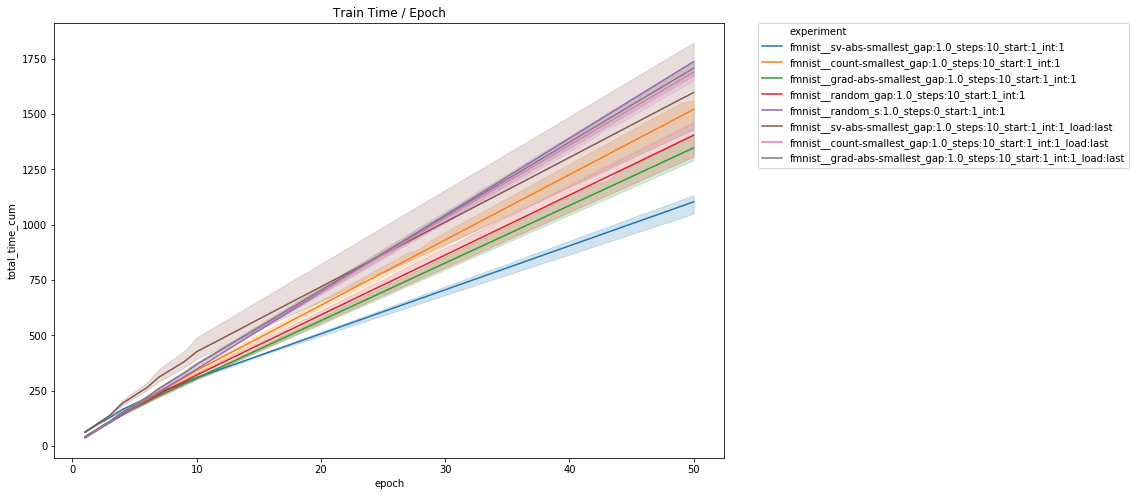

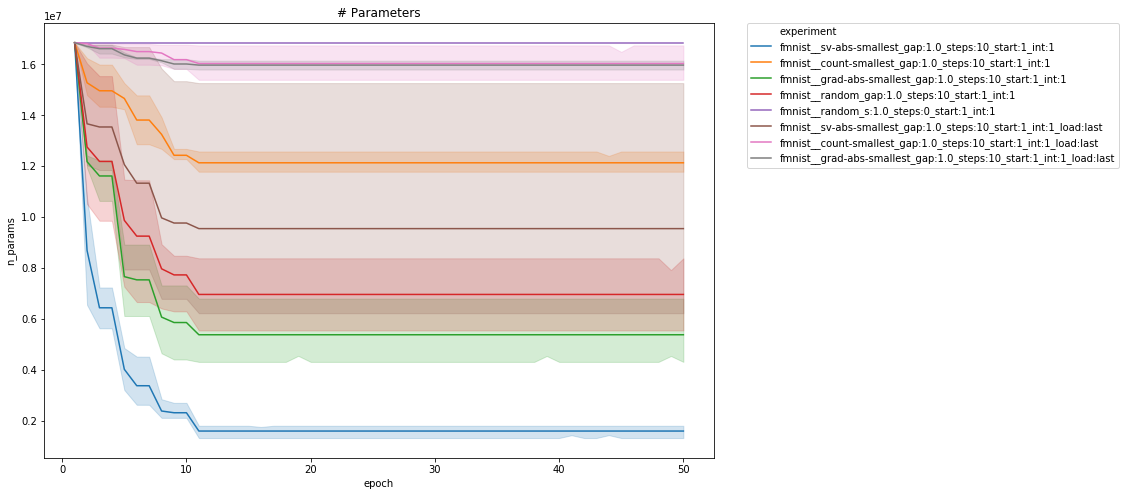

In [10]:


print ("Accuracy")
performance_df = plot_df.groupby(['experiment', 'timestamp']).max()
performance_df = performance_df.groupby(['experiment']).mean()
# print (performance_df.filter(items=["experiment", "test_acc"]))

# Print train time
print ("Training time")
time_df = plot_df.groupby(['experiment', 'timestamp']).sum()
time_df = time_df.groupby(['experiment']).mean()
cum_time_df = plot_df
cum_time_df['total_time_cum'] = plot_df.groupby(['experiment', 'timestamp'])['total_time'].transform(pd.Series.cumsum)
# print (cum_time_df)
# print (time_df.filter(items=["experiment", "train_time", "prune_time", "total_time"]))

# Weight sparsity
print ("Sparsity")
initial_params = np.max(list(plot_df.groupby(['experiment'])["n_params"].max()))
# print (initial_params)
sparsity_df = plot_df.groupby(['experiment', 'timestamp']).min()
sparsity_df = sparsity_df.groupby(['experiment']).min()
# print (sparsity_df.filter(items=["experiment", "n_params"]) / initial_params * 100)


# for label in plotting_data:
plt.figure(figsize=(12,8))
sns.lineplot(x="epoch", y="test_acc", hue="experiment", data = plot_df)
plt.title("Accuracy")
plt.ylim([0.0, 1.0])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# plt.figure(figsize=(12,8))
# new_plot = plot_df
# new_plot["train_time_cum"] = new_plot.groupby(['experiment', 'timestamp'])['train_time'].apply(lambda x: x.cumsum())
# sns.lineplot(x="train_time_cum", y="test_acc", hue="experiment", data = new_plot)
# plt.title("Accuracy / Wall-clock Time")
# plt.ylim([0.8, 0.98])
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure(figsize=(12,8))
ax = sns.lineplot(x="epoch", y="test_loss", hue="experiment", data = plot_df)
plt.title("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure(figsize=(12,8))
ax = sns.lineplot(x="epoch", y="train_loss", hue="experiment", data = plot_df)
plt.title("Train Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure(figsize=(12,8))
ax = sns.lineplot(x="epoch", y="total_time_cum", hue="experiment", data = cum_time_df)
plt.title("Train Time / Epoch")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure(figsize=(12,8))
ax = sns.lineplot(x="epoch", y="n_params", hue="experiment", data = plot_df)
plt.title("# Parameters")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
